# Applying Machine Learning on UrbanSound8k 

In [11]:
!date

Fri Mar  5 15:38:25 UTC 2021


In [12]:
# 挂载谷歌网盘
# Colaboratory: Can I access to my Google drive folder and file? 
# https://stackoverflow.com/questions/47744131/colaboratory-can-i-access-to-my-google-drive-folder-and-file
 
from google.colab import drive
drive.mount('/content/drive')

# 测试谷歌网盘
base_path = '/content/drive/MyDrive/dataset/sound_classification_ml_production/'

!pwd
!ls -la /content/drive/MyDrive/dataset/sound_classification_ml_production
!pwd
!ls -la .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
total 6051
drwx------ 2 root root    4096 Jan 30 06:12  audio_files
-rw------- 1 root root 3120372 Mar  5 11:13 'dataset (1).json'
-rw------- 1 root root 3014027 Mar  5 11:32  dataset.json
drwx------ 2 root root    4096 Feb  8 06:27  features_mfcc_0
drwx------ 2 root root    4096 Jan 30 06:12  flask_app
drwx------ 2 root root    4096 Jan 30 06:12  .git
-rw------- 1 root root     595 Mar  5 11:56  .gitignore
drwx------ 2 root root    4096 Jan 30 06:12  images
-rw------- 1 root root    1072 Mar  5 10:33  LICENSE
drwx------ 2 root root    4096 Mar  5 11:17  my_features_mfcc
drwx------ 2 root root    4096 Feb  7 07:21  my_features_mfcc_0
drwx------ 2 root root    4096 Feb 26 06:09  my_features_mfcc_1
drwx------ 2 root root    4096 Mar  5 10:53  my_features_mfcc_2
drwx------ 2 root root    4096 Jan 30 06:12  notebooks
-rw------- 1 root root    9441 Mar  5

## Install Packages

We install: 
- Machine learning libraries: `Keras`, `sklearn`
- Audio processing: `librosa`
- Plots: `Plotly`, `matplotlib`

In [13]:
!pip install pandas
!pip install setuptools
!pip install numpy
!pip install sklearn
!pip install librosa
!pip install plotly
!pip install matplotlib
!pip install pillow
!pip install keras

In [14]:
import os
import time
import librosa
import zipfile
import numpy as np
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image

In [15]:
# Unzip dataset
# !wget -P /content/drive/MyDrive/dataset/sound_classification_ml_production https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz 
# !mkdir /content/drive/MyDrive/dataset/sound_classification_ml_production/UrbanSound8K
# !tar -xzf UrbanSound8K.tar.gz -C /content/drive/MyDrive/dataset/sound_classification_ml_production/UrbanSound8K
# !rm urban8k.tgz

!ls -la /content/drive/MyDrive/dataset/sound_classification_ml_production/UrbanSound8K
# !mv /content/drive/MyDrive/dataset/sound_classification_ml_production/UrbanSound8K.tar.gz .


total 55
drwx------ 2 root root  4096 Jan 30 07:34 audio
-rw------- 1 root root 15364 May 19  2014 .DS_Store
-rw------- 1 root root 26155 May 19  2014 FREESOUNDCREDITS.txt
drwx------ 2 root root  4096 May 28  2014 metadata
-rw------- 1 root root  4932 Jun  3  2014 UrbanSound8K_README.txt


In [16]:
!pwd & ls -la

# !mkdir /content/drive/MyDrive/dataset/sound_classification_ml_production/features_mfcc
# !cp ./features_mfcc/* /content/drive/MyDrive/dataset/sound_classification_ml_production/features_mfcc

/content
total 20
drwxr-xr-x 1 root root 4096 Mar  5 15:13 .
drwxr-xr-x 1 root root 4096 Mar  5 15:10 ..
drwxr-xr-x 4 root root 4096 Mar  1 14:35 .config
drwx------ 5 root root 4096 Mar  5 15:13 drive
drwxr-xr-x 1 root root 4096 Mar  1 14:35 sample_data


## Design Choices and Models

After analysing the dataset and spending a bit of time reading about state-of-the-art on audio signal classification, and some of my [previous work](https://github.com/jsalbert/Music-Genre-Classification-with-Deep-Learning) I have made the following design choices and proposals:

Train a Convolutional Neural Network and use either MFCCs, STFT or Mel-Spectogram as input. 

- As the audios duration range from 0 to 4s, I pad the spectogram generated, to make all the audios of equal length. 

Feature options:

- Using MFCCs as features:
  - It is usual to compute the first 13 MFCCs, their derivatives and second derivatives and use it as features.
  - Or it is also usual to use 40 MFCCs as it is the Librosa default.

- Using the STFT as features:
  - Contains less human processing than MFCCs and Mel-Spectogram, the CNN could learn other filters rather than the representations designed by humans.

- Using Mel-Spectogram as features:
  - A transformation applied on the STFT that approximates how humans perceive the sound. Less human engineered than MFCCs but a bit more than STFT. 

My first choice would be using STFT and Mel-Spectogram as it looks that CNNs could take more advantage of the frequency-temporal structure but due to **computational resources** and limited time I will show the use **MFCCs** as features as they are much more memory efficient. 
 

## Dataset Preprocessing and Splits

I load all the audio data using Librosa and the default sample rate of 22050Hz. This design decision is based on 
([Source]((https://librosa.org/blog/2019/07/17/resample-on-load/#Okay...-but-why-22050-Hz?--Why-not-44100-or-48000?))) and in further experiments different sample rates could be tried. 

> Humans can hear up to around 20000 Hz, it's possible to successfully analyze music and speech data at much lower rates without sacrificing much. The highest pitches we usually care about detecting are around C9≈8372 Hz, well below the 11025 cutoff implied by fs=22050.

By default Librosa will load the audio in mono, giving us 1 channel.



In [17]:
# FeatureExtractor class including librosa audio processing functions
class FeatureExtractor:
    def __init__(self, csv_file):
        self.csv_file = csv_file
        self.max_audio_duration = 4
        self.dataset_df = self._create_dataset(csv_file)
    
    @staticmethod
    def _create_dataset(csv_file):
        """
        Args:
            dataset_path: path with the .wav files after unzipping
        Returns: A pandas dataframe with the list of files and labels (`filenames`, `labels`)
        """
        dataset_df = pd.read_csv(csv_file)
        filepaths = []
        for i, row in dataset_df.iterrows():
            filepaths.append(os.path.join('UrbanSound8K/audio', 'fold'+str(row['fold']), row['slice_file_name']))
        dataset_df['filepath'] = filepaths
        return dataset_df

    @staticmethod
    def _compute_max_pad_length(max_audio_length, sample_rate=22050, n_fft=2048, hop_length=512):
        dummy_file = np.random.random(max_audio_length*sample_rate)
        stft = librosa.stft(dummy_file, n_fft=n_fft, hop_length=hop_length)
        # Return an even number for CNN computation purposes
        if stft.shape[1] % 2 != 0:
            return stft.shape[1] + 1
        return stft.shape[1]

    def compute_save_features(self, 
                        mode='mfcc', 
                        sample_rate=22050,
                        n_fft=2048,
                        hop_length=512,
                        n_mfcc=40,
                        output_path='features',
                        deltas=False
                        ):
        dataset_features = []
        max_pad = self._compute_max_pad_length(self.max_audio_duration, 
                                               sample_rate=sample_rate, 
                                               n_fft=n_fft,
                                               hop_length=hop_length)
        print('Max Padding = ', max_pad)
        
        if not os.path.exists(output_path):
            print('Creating output folder: ', output_path)
            os.makedirs(output_path)
        else:
            print('Output folder already existed')
            
        print('Saving features in ', output_path)
        i = 0
        t = time.time()
        
        features_path = []
        for relative_filepath in self.dataset_df['filepath']:
            filepath = base_path + relative_filepath;
            print('compute_save_features, filepath = ' + str(filepath))

            if i % 100 == 0:
                print('{} files processed in {}s'.format(i, time.time() - t))

            print('compute_save_features, librosa.load, filepath = ' + str(filepath))
            audio_file, sample_rate = librosa.load(filepath, sr=sample_rate, res_type='kaiser_fast')
            if mode == 'mfcc':
                audio_features = self.compute_mfcc(audio_file, sample_rate, n_fft, hop_length, n_mfcc, deltas)  
            elif mode == 'stft':
                audio_features = self.compute_stft(audio_file, sample_rate, n_fft, hop_length)
            elif mode == 'mel-spectogram':
                audio_features = self.compute_mel_spectogram(audio_file, sample_rate, n_fft, hop_length)
            
            audio_features = np.pad(audio_features, pad_width=((0, 0), (0, max_pad - audio_features.shape[1])))
            print('compute_save_features, audio_features = ' + str(type(audio_features)) + ', ' + str(audio_features.shape))

            # here save .npy feature as shape(39, 174, 1)
            npy_path = os.path.join(output_path, filepath.split('/')[-1].replace('wav', 'npy'))
            print('compute_save_features, npy_path = ' + str(npy_path))
            print('compute_save_features, audio_features.shape = ' + str(audio_features.shape))
            tmp_audio_features = audio_features.reshape(audio_features.shape[0], audio_features.shape[1], 1)
            print('compute_save_features, tmp_audio_features.shape = ' + str(tmp_audio_features.shape))
            np.save(npy_path, tmp_audio_features)
            
            save_path = os.path.join(output_path, filepath.split('/')[-1].replace('wav', 'png'))
            print('compute_save_features, save_features, save_path = ' + str(save_path))
            print('compute_save_features, audio_features.shape = ' + str(audio_features.shape))
            self.save_features(audio_features, save_path)
            features_path.append(save_path)
            i+=1
        self.dataset_df['features_path'] = features_path
        return self.dataset_df
    
    @staticmethod
    def save_features(audio_features, filepath):
        image = Image.fromarray(audio_features)
        # To grayscale
        image = image.convert("L")
        image.save(filepath)
        print('save_features, filepath = ' + str(filepath))

    @staticmethod
    def compute_mel_spectogram(audio_file, sample_rate, n_fft, hop_length):
        return librosa.feature.melspectrogram(audio_file,
                                              sr=sample_rate, 
                                              n_fft=n_fft,
                                              hop_length=hop_length)
    @staticmethod
    def compute_stft(audio_file, sample_rate, n_fft, hop_length):
        return librosa.stft(audio_file, n_fft=n_fft, hop_length=hop_length)
    
    @staticmethod
    def compute_mfcc(audio_file, sample_rate, n_fft, hop_length, n_mfcc, deltas=False):
        mfccs = librosa.feature.mfcc(audio_file,
                                    sr=sample_rate, 
                                    n_fft=n_fft,
                                    n_mfcc=n_mfcc,
                                    )
        # Change mode from interpolation to nearest
        if deltas:
          delta_mfccs = librosa.feature.delta(mfccs, mode='nearest')
          delta2_mfccs = librosa.feature.delta(mfccs, order=2, mode='nearest')
          return np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
        return mfccs

In [18]:
# Create dataset and extract features
fe = FeatureExtractor(base_path + 'UrbanSound8K/metadata/UrbanSound8K.csv')

Access to disc and librosa loading of audio files is very slow on colab Notebook (30-40 min) we could load the pre-computed features instead.

In [ ]:
# Uncomment and run to compute and save features on the colab notebook
dataset_df = fe.compute_save_features(mode='mfcc', n_mfcc=13, output_path=base_path + 'my_features_mfcc', deltas=True)

Streaming output truncated to the last 5000 lines.
compute_save_features, audio_features = <class 'numpy.ndarray'>, (39, 174)
compute_save_features, npy_path = /content/drive/MyDrive/dataset/sound_classification_ml_production/my_features_mfcc/159750-8-0-1.npy
compute_save_features, audio_features.shape = (39, 174)
compute_save_features, tmp_audio_features.shape = (39, 174, 1)
compute_save_features, filepath = /content/drive/MyDrive/dataset/sound_classification_ml_production/UrbanSound8K/audio/fold2/159750-8-0-2.wav
compute_save_features, librosa.load, filepath = /content/drive/MyDrive/dataset/sound_classification_ml_production/UrbanSound8K/audio/fold2/159750-8-0-2.wav
compute_save_features, audio_features = <class 'numpy.ndarray'>, (39, 174)
compute_save_features, npy_path = /content/drive/MyDrive/dataset/sound_classification_ml_production/my_features_mfcc/159750-8-0-2.npy
compute_save_features, audio_features.shape = (39, 174)
compute_save_features, tmp_audio_features.shape = (39, 174

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning:

n_fft=2048 is too small for input signal of length=1323



Streaming output truncated to the last 5000 lines.
compute_save_features, npy_path = /content/drive/MyDrive/dataset/sound_classification_ml_production/my_features_mfcc/72259-1-1-0.npy
compute_save_features, audio_features.shape = (39, 174)
compute_save_features, tmp_audio_features.shape = (39, 174, 1)
compute_save_features, filepath = /content/drive/MyDrive/dataset/sound_classification_ml_production/UrbanSound8K/audio/fold5/72259-1-10-0.wav
7500 files processed in 789.9762582778931s
compute_save_features, librosa.load, filepath = /content/drive/MyDrive/dataset/sound_classification_ml_production/UrbanSound8K/audio/fold5/72259-1-10-0.wav
compute_save_features, audio_features = <class 'numpy.ndarray'>, (39, 174)
compute_save_features, npy_path = /content/drive/MyDrive/dataset/sound_classification_ml_production/my_features_mfcc/72259-1-10-0.npy
compute_save_features, audio_features.shape = (39, 174)
compute_save_features, tmp_audio_features.shape = (39, 174, 1)
compute_save_features, filep

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning:

n_fft=2048 is too small for input signal of length=1103

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning:

n_fft=2048 is too small for input signal of length=1523



compute_save_features, audio_features = <class 'numpy.ndarray'>, (39, 174)
compute_save_features, npy_path = /content/drive/MyDrive/dataset/sound_classification_ml_production/my_features_mfcc/87562-6-0-0.npy
compute_save_features, audio_features.shape = (39, 174)
compute_save_features, tmp_audio_features.shape = (39, 174, 1)
compute_save_features, filepath = /content/drive/MyDrive/dataset/sound_classification_ml_production/UrbanSound8K/audio/fold10/88121-8-0-0.wav
compute_save_features, librosa.load, filepath = /content/drive/MyDrive/dataset/sound_classification_ml_production/UrbanSound8K/audio/fold10/88121-8-0-0.wav
compute_save_features, audio_features = <class 'numpy.ndarray'>, (39, 174)
compute_save_features, npy_path = /content/drive/MyDrive/dataset/sound_classification_ml_production/my_features_mfcc/88121-8-0-0.npy
compute_save_features, audio_features.shape = (39, 174)
compute_save_features, tmp_audio_features.shape = (39, 174, 1)
compute_save_features, filepath = /content/drive

In [ ]:
# Unzip features
# !wget -P /content/drive/MyDrive/dataset/sound_classification_ml_production --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1BU2B5EcbfyGBIOkB5YC44hpzPpuqw43H' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1BU2B5EcbfyGBIOkB5YC44hpzPpuqw43H" -O features_mfcc.zip && rm -rf /tmp/cookies.txt
# !unzip -q /content/drive/MyDrive/dataset/sound_classification_ml_production/features_mfcc.zip
# !rm features_mfcc.zip

In [ ]:
# Download dataset.json file
# !wget -P /content/drive/MyDrive/dataset/sound_classification_ml_production --no-check-certificate "https://docs.google.com/uc?export=download&id=1pzSvGYaBXghLQFTZxlSex-Ts3T4B0X4C" -O dataset.json

In [ ]:
dataset_path = base_path + 'dataset.json'
print(dataset_path)
dataset_df = pd.read_json(dataset_path)

/content/drive/MyDrive/dataset/sound_classification_ml_production/dataset.json


For the purpose of this experiment we will load all the data in memory and process it in minibatches. If we had computational resources and more time we could create Dataloader objects that would allow to perform many other operations as Data Augmentation and iterate faster. 

In [ ]:
tmp = []
for relative_feature_path in dataset_df['features_path']:
 
  feature_path = base_path + relative_feature_path.replace('features_mfcc', 'my_features_mfcc')
  print('feature_path = ' + str(feature_path))
 
  tmp.append(feature_path)

Streaming output truncated to the last 5000 lines.
feature_path = /content/drive/MyDrive/dataset/sound_classification_ml_production/my_features_mfcc/17592-5-0-0.npy
feature_path = /content/drive/MyDrive/dataset/sound_classification_ml_production/my_features_mfcc/17592-5-1-0.npy
feature_path = /content/drive/MyDrive/dataset/sound_classification_ml_production/my_features_mfcc/17592-5-1-1.npy
feature_path = /content/drive/MyDrive/dataset/sound_classification_ml_production/my_features_mfcc/17592-5-1-2.npy
feature_path = /content/drive/MyDrive/dataset/sound_classification_ml_production/my_features_mfcc/17592-5-1-3.npy
feature_path = /content/drive/MyDrive/dataset/sound_classification_ml_production/my_features_mfcc/176003-1-0-0.npy
feature_path = /content/drive/MyDrive/dataset/sound_classification_ml_production/my_features_mfcc/17615-3-0-0.npy
feature_path = /content/drive/MyDrive/dataset/sound_classification_ml_production/my_features_mfcc/17615-3-0-3.npy
feature_path = /content/drive/MyDriv

In [ ]:
# Numpy：numpy与image互转 https://blog.csdn.net/weixin_40522801/article/details/106490005

dataset_df['features'] = [np.asarray(np.load(base_path + feature_path.replace('features_mfcc', 'my_features_mfcc'))) for feature_path in dataset_df['features_path']]

In [ ]:
from keras.utils import to_categorical
dataset_df['labels_categorical'] = [to_categorical(label, 10) for label in dataset_df['classID']]

In [ ]:
dataset_df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath,features_path,features,labels_categorical
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,UrbanSound8K/audio/fold5/100032-3-0-0.wav,features_mfcc/100032-3-0-0.npy,"[[[-306.77255], [-177.59209], [-99.13616], [-6...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-117.wav,features_mfcc/100263-2-0-117.npy,"[[[-457.69534], [-451.0248], [-450.68613], [-4...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-121.wav,features_mfcc/100263-2-0-121.npy,"[[[-468.0367], [-467.42264], [-481.04654], [-4...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-126.wav,features_mfcc/100263-2-0-126.npy,"[[[-422.42215], [-411.9085], [-409.46243], [-4...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-137.wav,features_mfcc/100263-2-0-137.npy,"[[[-438.10162], [-434.47787], [-443.3284], [-4...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


We are going to create splits for the train, validation and test sets of our dataset. 
For the purpose of the experiment and to make it quick we will use the sklearn function `train_test_split`, two times. 

In [ ]:
dataset_df_tolist = dataset_df['features'].tolist()
np_array = np.array(dataset_df_tolist)
print('dataset_df_tolist = ' + str(dataset_df_tolist))
print('np_array = ' + str(np_array))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# Split the dataset 
from sklearn.model_selection import train_test_split 

# Add one dimension for the channel
X = np.array(dataset_df['features'].tolist())
y = np.array(dataset_df['labels_categorical'].tolist())

# As there is unbalance for some classes I am going to stratify it so we have the same proportion in train/test
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.30, 
                                                    random_state=1, 
                                                    stratify=y)
# Create validation and test
X_test, X_val, Y_test, Y_val = train_test_split(X_test, 
                                                Y_test, 
                                                test_size=0.5, 
                                                random_state=1, 
                                                stratify=Y_test)

print(X_train.shape, X_val.shape, X_test.shape)

(6112, 39, 174, 1) (1310, 39, 174, 1) (1310, 39, 174, 1)


## Machine Learning Model

### Model Design

We are going to create a **Fully Convolutional Network** Model using Keras running over Tensorflow with a few layers. 

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D

As our images are rectangular in shape (y axis is MFCC, x axis is time), instead of using square filters (as usual) we are going to make them rectangular so they can learn better the correlation of the MFCCs with the temporal dimension. 

In [ ]:
# FCN Model
def create_model(num_classes=10, input_shape=None, dropout_ratio=None):
    model = Sequential()
    if input_shape is None:
        model.add(Input(shape=(None, None, 1)))
    else:
        model.add(Input(shape=input_shape))
    model.add(Conv2D(filters=16, kernel_size=(2, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 3)))
    model.add(Conv2D(filters=32, kernel_size=(2, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=(2, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=128, kernel_size=(2, 4), activation='relu'))
    model.add(GlobalAveragePooling2D())
    if dropout_ratio is not None:
        model.add(Dropout(dropout_ratio))
    # Add dense linear layer
    model.add(Dense(num_classes, activation='softmax'))
    return model

As it is a multi classification problem we will use the **Categorical Cross Entropy loss**. As optimizer we will use the Keras implementation of **Adam** with the default hyperparameters values. 

In [ ]:
# Create and compile the model
fcn_model = create_model(input_shape=X_train.shape[1:])
fcn_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
fcn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 38, 171, 16)       144       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 19, 57, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 18, 54, 32)        4128      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 9, 27, 32)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 24, 64)         16448     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 12, 64)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 9, 128)        

### Model training and evaluation

In [ ]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint 

In [ ]:
!mkdir /content/drive/MyDrive/dataset/sound_classification_ml_production/saved_models

mkdir: cannot create directory ‘/content/drive/MyDrive/dataset/sound_classification_ml_production/saved_models’: File exists


In [ ]:
def train_model(model, X_train, Y_train, X_val, Y_val, epochs, batch_size, callbacks):
    model.fit(X_train, 
              Y_train, 
              batch_size=batch_size, 
              epochs=epochs, 
              validation_data=(X_val, Y_val), 
              callbacks=callbacks, verbose=1)
    return model

We will create a checkpoint for **early stopping**, so we will select the model that performs better on the validation set. 

Creating a function to train the model will allow us to perform hyperparameter tuning faster. 

In [ ]:
checkpointer = ModelCheckpoint(filepath=base_path + 'saved_models/best_fcn.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
callbacks = [checkpointer]

# Hyper-parameters
epochs = 100
batch_size = 256

In [ ]:
# Train the model
model = train_model(model=fcn_model,
                    X_train=X_train,
                    X_val=X_val,
                    Y_train=Y_train,
                    Y_val=Y_val,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks)

Epoch 1/100
24/24 [==============================] - 2s 48ms/step - loss: 2.6188 - accuracy: 0.1969 - val_loss: 1.6788 - val_accuracy: 0.4084

Epoch 00001: val_accuracy improved from -inf to 0.40840, saving model to /content/drive/MyDrive/dataset/sound_classification_ml_production/saved_models/best_fcn.hdf5
Epoch 2/100
24/24 [==============================] - 1s 36ms/step - loss: 1.5436 - accuracy: 0.4631 - val_loss: 1.3812 - val_accuracy: 0.4893

Epoch 00002: val_accuracy improved from 0.40840 to 0.48931, saving model to /content/drive/MyDrive/dataset/sound_classification_ml_production/saved_models/best_fcn.hdf5
Epoch 3/100
24/24 [==============================] - 1s 37ms/step - loss: 1.3061 - accuracy: 0.5344 - val_loss: 1.2761 - val_accuracy: 0.5336

Epoch 00003: val_accuracy improved from 0.48931 to 0.53359, saving model to /content/drive/MyDrive/dataset/sound_classification_ml_production/saved_models/best_fcn.hdf5
Epoch 4/100
24/24 [==============================] - 1s 37ms/step -

In [ ]:
# Load the best model
best_model = load_model(base_path + 'saved_models/best_fcn.hdf5')

# !ls /content/drive/MyDrive/dataset/sound_classification_ml_production/saved_models

Looks like the model has overfitted to the training data towards the end of the training. We have selected the model that performed better on the validation set, saved by the checkpoint. The similarity between validation and test score tells us that our training methodology is correct and that our validation set is a good estimator of testing performance. 

In [ ]:
# Evaluating the model on the training and testing set
score = best_model.evaluate(X_train, Y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = best_model.evaluate(X_val, Y_val, verbose=0)
print("Validation Accuracy: ", score[1])

score = best_model.evaluate(X_test, Y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9919829964637756
Validation Accuracy:  0.9221373796463013
Testing Accuracy:  0.8931297659873962


We see that there has been overfitting so we could train another model adding dropout before the last layer to add more regularization.  

In [ ]:
# We add a dropout ratio of 0.25
fcn_model = create_model(input_shape=X_train.shape[1:], dropout_ratio=0.5)
fcn_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
fcn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 38, 171, 16)       144       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 19, 57, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 18, 54, 32)        4128      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 9, 27, 32)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 24, 64)         16448     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 12, 64)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 3, 9, 128)        

In [ ]:
checkpointer = ModelCheckpoint(filepath=base_path + 'saved_models/best_fcn_dropout.hdf5', monitor='val_accuracy',
                               verbose=1, save_best_only=True)
callbacks = [checkpointer]

model = train_model(model=fcn_model,
                    X_train=X_train,
                    X_val=X_val,
                    Y_train=Y_train,
                    Y_val=Y_val,
                    epochs=200,
                    batch_size=256,
                    callbacks=callbacks)

Epoch 1/200
24/24 [==============================] - 2s 46ms/step - loss: 2.6688 - accuracy: 0.1748 - val_loss: 1.7661 - val_accuracy: 0.4168

Epoch 00001: val_accuracy improved from -inf to 0.41679, saving model to /content/drive/MyDrive/dataset/sound_classification_ml_production/saved_models/best_fcn_dropout.hdf5
Epoch 2/200
24/24 [==============================] - 1s 37ms/step - loss: 1.7413 - accuracy: 0.3773 - val_loss: 1.3962 - val_accuracy: 0.5099

Epoch 00002: val_accuracy improved from 0.41679 to 0.50992, saving model to /content/drive/MyDrive/dataset/sound_classification_ml_production/saved_models/best_fcn_dropout.hdf5
Epoch 3/200
24/24 [==============================] - 1s 36ms/step - loss: 1.4353 - accuracy: 0.4964 - val_loss: 1.2150 - val_accuracy: 0.5733

Epoch 00003: val_accuracy improved from 0.50992 to 0.57328, saving model to /content/drive/MyDrive/dataset/sound_classification_ml_production/saved_models/best_fcn_dropout.hdf5
Epoch 4/200
24/24 [========================

In [ ]:
best_model = load_model(base_path + 'saved_models/best_fcn_dropout.hdf5')

# !ls /content/drive/MyDrive/dataset/sound_classification_ml_production/saved_models

In [ ]:
# Evaluating the model on the training and testing set
score = best_model.evaluate(X_train, Y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = best_model.evaluate(X_val, Y_val, verbose=0)
print("Validation Accuracy: ", score[1])

score = best_model.evaluate(X_test, Y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9978730082511902
Validation Accuracy:  0.9160305261611938
Testing Accuracy:  0.9068702459335327


In [ ]:
# Plot a confusion matrix
from sklearn import metrics
Y_pred = best_model.predict(X_test)
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))

In [ ]:
# Confusion matrix code (from https://github.com/triagemd/keras-eval/blob/master/keras_eval/visualizer.py)
def plot_confusion_matrix(cm, concepts, normalize=False, show_text=True, fontsize=18, figsize=(16, 12),
                          cmap=plt.cm.coolwarm_r, save_path=None, show_labels=True):
    '''
    Plot confusion matrix provided in 'cm'
    Args:
        cm: Confusion Matrix, square sized numpy array
        concepts: Name of the categories to show
        normalize: If True, normalize values between 0 and ones. Not valid if negative values.
        show_text: If True, display cell values as text. Otherwise only display cell colors.
        fontsize: Size of text
        figsize: Size of figure
        cmap: Color choice
        save_path: If `save_path` specified, save confusion matrix in that location
    Returns: Nothing. Plots confusion matrix
    '''

    if cm.ndim != 2 or cm.shape[0] != cm.shape[1]:
        raise ValueError('Invalid confusion matrix shape, it should be square and ndim=2')

    if cm.shape[0] != len(concepts) or cm.shape[1] != len(concepts):
        raise ValueError('Number of concepts (%i) and dimensions of confusion matrix do not coincide (%i, %i)' %
                         (len(concepts), cm.shape[0], cm.shape[1]))

    plt.rcParams.update({'font.size': fontsize})

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if normalize:
        cm = cm_normalized

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, vmin=np.min(cm), vmax=np.max(cm), alpha=0.8, cmap=cmap)

    fig.colorbar(cax)
    ax.xaxis.tick_bottom()
    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')

    if show_labels:
        n_labels = len(concepts)
        ax.set_xticklabels(concepts)
        ax.set_yticklabels(concepts)
        plt.xticks(np.arange(0, n_labels, 1.0), rotation='vertical')
        plt.yticks(np.arange(0, n_labels, 1.0))
    else:
        plt.axis('off')

    if show_text:
        # http://stackoverflow.com/questions/21712047/matplotlib-imshow-matshow-display-values-on-plot
        min_val, max_val = 0, len(concepts)
        ind_array = np.arange(min_val, max_val, 1.0)
        x, y = np.meshgrid(ind_array, ind_array)
        for i, (x_val, y_val) in enumerate(zip(x.flatten(), y.flatten())):
            c = cm[int(x_val), int(y_val)]
            ax.text(y_val, x_val, c, va='center', ha='center')

    if save_path is not None:
        plt.savefig(save_path)

To observe better the performance of the model and the mistakes made between different classes we plot the confusion matrix. 

In our case accuracy is a good metric because the dataset is mostly balanced but we observed a few classes with less samples (1`car_horn`, `gun_shot` and `siren`), so it will be good to observe the performance on these classes.

We can observe that a lot of mistakes are happening between class `children_playing` and class `street_music` so maybe it will be worth it to spend a little bit more time doing analysis and finding what could be the reasons.  

In [ ]:
class_dictionary = {3: 'dog_bark', 2: 'children_playing', 1: 'car_horn', 0: 'air_conditioner', 9: 'street_music', 6: 'gun_shot', 8: 'siren', 5: 'engine_idling', 7: 'jackhammer', 4: 'drilling'}
classes = [class_dictionary[key] for key in sorted(class_dictionary.keys())]

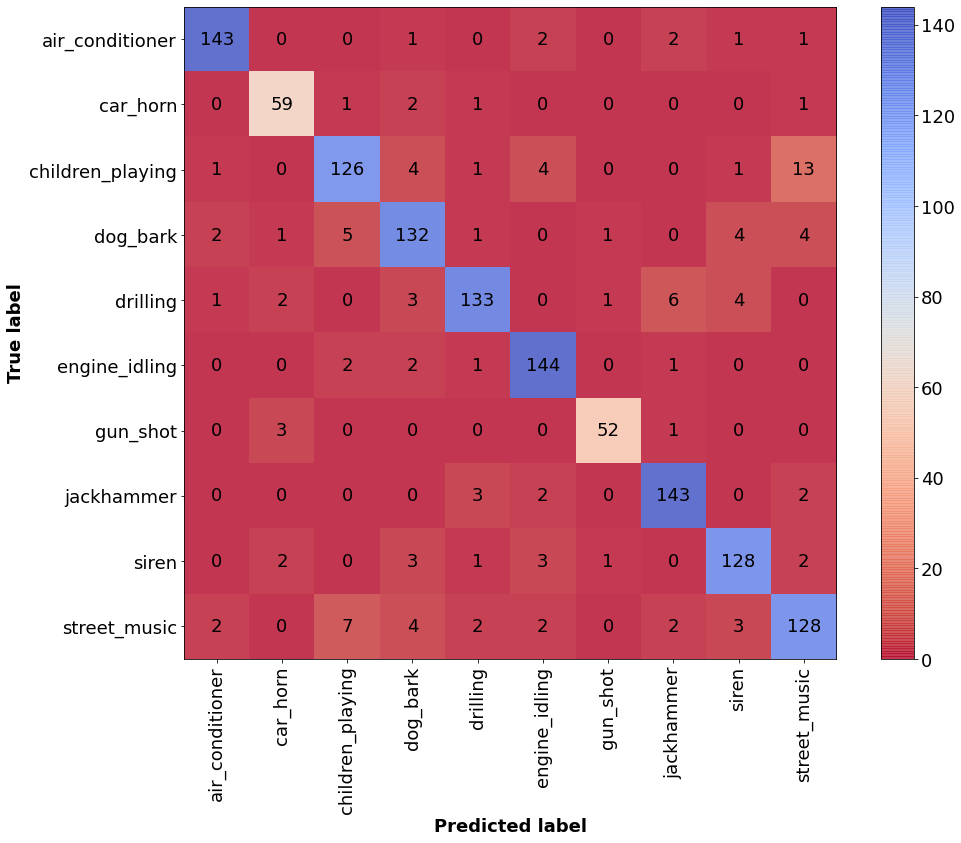

In [ ]:
plot_confusion_matrix(matrix, classes)

## Conclusions

We can observe a bump of 1-2% in the test set accuracy when introducing dropout as regularization. This shows that it has been a successful addition to our model.

There are many things that we can try to improve the model's performance such as:

- Hyperparameter tuning:
  - Tuning the parameters of feature extraction
  - Tuning the network parameters (number of layers, pooling layers, number and filter shape...)
  - Tuning the network hyperparameters (Learning rate, optimizer) 

- Feature extraction:
  - Use STFT: The raw spectogram could provide more information to the CNN to learn correlation between frequency and time than the MFCCs.
  - Use Mel-Spectogram: The mel-spectogram could provide more information to the CNN to learn correlation between frequency and time than the MFCCs. 

In [ ]:
!ls /content/drive/MyDrive/dataset/audio_classifier_tutorial/UrbanSound8K

ls: cannot access '/content/drive/MyDrive/dataset/audio_classifier_tutorial/UrbanSound8K': No such file or directory


In [ ]:
# import matplotlib
# matplotlib.use('Agg')
import os

import librosa
from tensorflow.keras.models import load_model
import numpy as np
# from PIL import Image
# import cv2

#加载模型h5文件

# 读取音频数据
def load_data(data_path):
    wav, sr = librosa.load(data_path, sr=16000)
    intervals = librosa.effects.split(wav, top_db=20)
    wav_output = []
    for sliced in intervals:
        wav_output.extend(wav[sliced[0]:sliced[1]])
    assert len(wav_output) >= 8000, "有效音频小于0.5s"
    wav_output = np.array(wav_output)
    ps = librosa.feature.melspectrogram(y=wav_output, sr=sr, hop_length=256).astype(np.float32)
    ps = ps[np.newaxis, ..., np.newaxis]
    return ps

load_data_car_119_10785 = load_data('/content/drive/MyDrive/dataset/audio_classifier_tutorial/UrbanSound8K/predict/car_119_10785.wav')
best_model.predict(load_data_car_119_10785)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning:

PySoundFile failed. Trying audioread instead.



FileNotFoundError: ignored

In [ ]:
!date